In [1]:
%run load_dependencies.ipynb
%run misc_functions.ipynb
%run connect_to_api.ipynb
%run live_monitoring.ipynb

In [3]:
def cooccurring_objects_report(obj,hit_type = 'hashtags',days = 7, live_maps = False,sheet = False,search = 'hitcache',tag = False,second_order = True):
    if search == 'load':
        tweets_df = pd.read_excel(f'/Users/avneeshchandra/Analyst_tools/avneesh/tweets_{obj}.xlsx')
        tweets_df.mentions = tweets_df.mentions.apply(literal_eval)
        tweets_df.hashtags = tweets_df.hashtags.apply(literal_eval)
        tweets_df.urls = tweets_df.urls.apply(literal_eval)
    if search == 'hitcache':
        hits_df = check_hitcache(hit_type,obj,days,limit = False,live = live_maps)
        hits_df = apply_tags(hits_df)
        tweets_df = get_full_tweets(hits_df.message_id.unique().tolist())
        tweets_df = tweets_df.merge(hits_df[['message_id','tag']],left_on = 'tweet_id',right_on = 'message_id')
    elif search == 'twitter':
        tweets_df = search_tweets(obj)

    objects = {}
    tweets_df.to_excel('tweets_{}.xlsx'.format(obj))
    
    for i in ['hashtags','urls','mentions']:
        objects[i] = tweets_df.explode(i).dropna()
        if i == 'hashtags':
            objects[i].hashtags = objects[i].hashtags.str.lower()
            
    to_write = {}
    for i in objects:
        if search == 'twitter':
            tag = False
        if tag:
            across = ['tag',i]
        else:
            across = i
#         display(pd.pivot_table(objects[i],index = i,values = ['tweet_id','user_id'],aggfunc = pd.Series.nunique))
        try:
            to_write[i] = pd.pivot_table(objects[i],index = across,values = ['tweet_id','user_id'],aggfunc = pd.Series.nunique)\
               .sort_values('user_id',ascending = False)\
               .head(100)
        except:
            continue
        to_write[i].columns = ['tweets','users']
        to_write[i] = to_write[i].reset_index()
    if second_order:
        to_write['second_order'] = pd.DataFrame()
        for i in objects:
            temp = pd.pivot_table(objects[i],index = i,values = ['tweet_id','user_id'],aggfunc = pd.Series.nunique)\
                       .sort_values('user_id',ascending = False)\
                       .head(100)
            for o in temp.index.values.tolist():
                if o == obj:
                    continue
                subset_ids = objects[i][objects[i][i] == o][['tweet_id']]
                subset = tweets_df.merge(subset_ids)
                subset = subset.explode(i)
                subset[i] = subset[i].str.lower()
                subset = subset[~(subset[i] == o)]
                subset = subset[~(subset[i] == obj)]
                if subset.empty:
                    continue
                subset = pd.pivot_table(subset,index = i,values = ['tweet_id','user_id'],aggfunc = pd.Series.nunique)\
                       .sort_values('user_id',ascending = False)\
                       .head(20)
                subset['first_' + i] = o
                to_write['second_order'] = to_write['second_order'].append(subset.reset_index().set_index(['first_'+i,i]))
            break
        to_write['second_order']= to_write['second_order'].reset_index()
        to_write['second_order'].columns = ['first_order','second_order','tweets','users']
        to_write['second_order'] = to_write['second_order'][to_write['second_order'].users > 3]
        
    if hit_type == 'hashtags':
        obj = '#' + obj
    elif hit_type == 'mentions':
        obj = '@' + obj
    
    if sheet:
        write_to_sheet(to_write,f'Co-Occurring Objects: {obj} – {str(datetime.now())[:10]}')
    else:
        write_to_file(to_write,f'../outputs/Co-Occurring Objects: {obj} – {str(datetime.now())[:10]}')


In [5]:
cooccurring_objects_report('alaqsa','hashtags',3,True,True,second_order = True)

...Getting 6431 tweets
...Done!
...Opening Sheet
...Writing hashtags
...Writing urls
...Writing mentions
...Writing second_order
...Sheet now has:
<Worksheet 'hashtags' id:1562677184> (101, 3)
<Worksheet 'urls' id:934533871> (101, 3)
<Worksheet 'mentions' id:1204410963> (101, 3)
<Worksheet 'second_order' id:1716744381> (1132, 4)
...Sheet available at: https://docs.google.com/spreadsheets/d/1LCXa_pbHSIUFE-3wZ5nIYQKCEF-zPs-RF6ceTwiwu2o


In [162]:
def get_mentions(df = pd.DataFrame()):
    if df.empty:
        df = check_hitcache('mentions','',1,live = True,limit = False)
        print(f'...Found {df.node_id.nunique()} accounts mentioning {df.hit_value.nunique()} users')
        #apply screennames
#         screennames_df = pd.read_csv('/Users/avneeshchandra/Downloads/all_screennames.csv')
        users_to_get = df.node_id.unique().tolist()
        users_to_get.extend(df.hit_value.unique().tolist())
        screennames_df = get_all_users(users_to_get)
        df = df.merge(screennames_df[['id_str','name','screen_name']],\
        left_on = 'hit_value',right_on = 'id_str')
        screennames_df.id = screennames_df.id.astype(str)
        df = df.merge(screennames_df[['id','created_at']],left_on = 'node_id',right_on = 'id')
        df = df.drop(columns = ['id','id_str'])
        df = apply_tags(df)
        return df
    else:
        return df

In [163]:
# screennames_df.to_csv('all_screennames.csv')
# print_csv(screennames_df.append(users_df))

In [164]:
mench = get_mentions()

...Found 70922 accounts mentioning 236203 users
...Getting 307125 users


In [174]:
mench = mench[~(mench.tag == 'Unknown')]

In [165]:
print(f'...Found {mench.node_id.nunique()} accounts mentioning {mench.hit_value.nunique()} users')

...Found 70832 accounts mentioning 234583 users


In [166]:
top_mench = pd.pivot_table(mench,index = ['name','screen_name','hit_value'],values = 'node_id',aggfunc = pd.Series.nunique)\
.sort_values('node_id',ascending = False)

In [167]:
rel_men = top_mench[top_mench.node_id > 999]
rel_men = rel_men[rel_men.node_id < 4000]

In [168]:
rel_men = rel_men.reset_index().hit_value.tolist()

In [55]:
def get_posting_gaps(df,col_name = 'hit_time'):
    df.created_at = pd.to_datetime(df.created_at, infer_datetime_format = True,utc = True)#format='%a %b %d %H:%M:%S %z %Y')

    df = df.sort_values(col_name,ascending = True)
    df = df.drop(columns = ['map_id','cluster_no']).drop_duplicates()

    gap = []
    created_gap = []
    midpoint = df.iloc[int(df.shape[0]/2)][col_name]
    peak = df[col_name].value_counts().index.values[0]
    now = pd.to_datetime(datetime.now(), infer_datetime_format = True,utc = True)
    for row in df.iterrows():
        i = row[1][col_name]

        try:
            gap.append(divmod(pd.Timedelta(i-peak).total_seconds(), 60)[0])
            created_days = divmod(abs(pd.Timedelta(row[1]['created_at']-now).total_seconds()), 86400)[0]
            created_gap.append(math.log(created_days,10))
        except:
            print('...Error')
            gap.append(0)
            created_gap.append(0)
            pass
        last = i
    df['gap'] = gap
    df['created_gap'] = created_gap
    return df

In [218]:
plt_args = {'size':17,'dims':(10,10)}

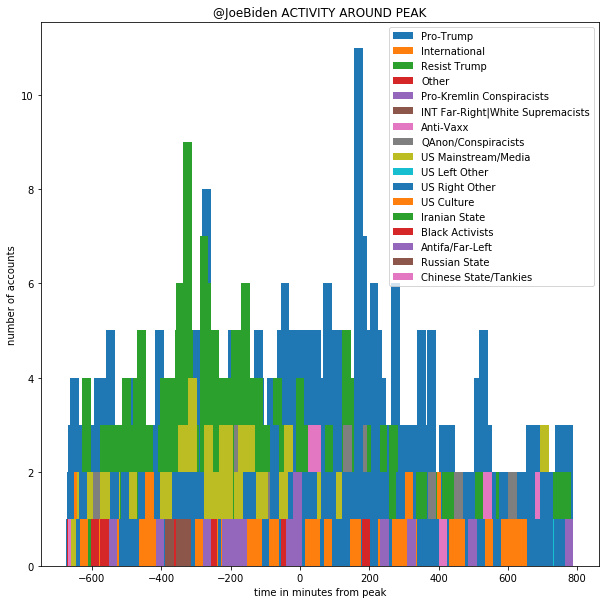

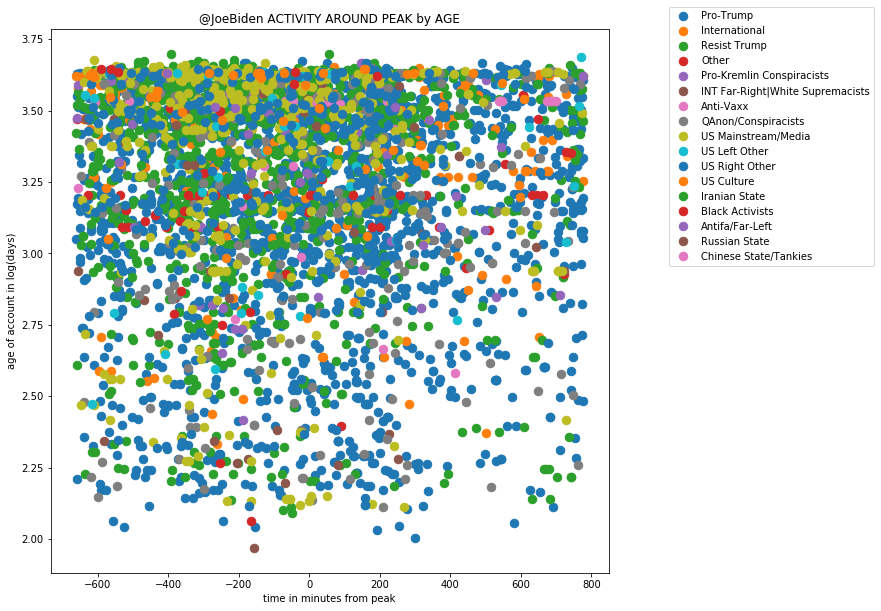

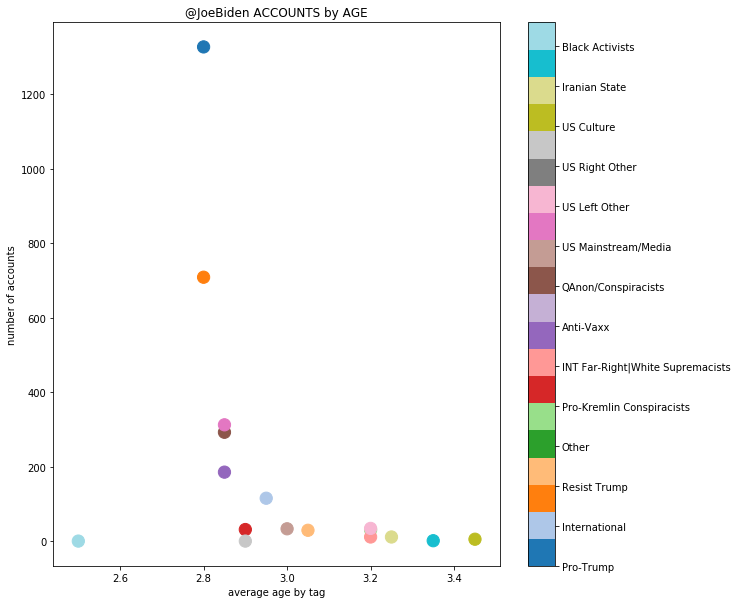

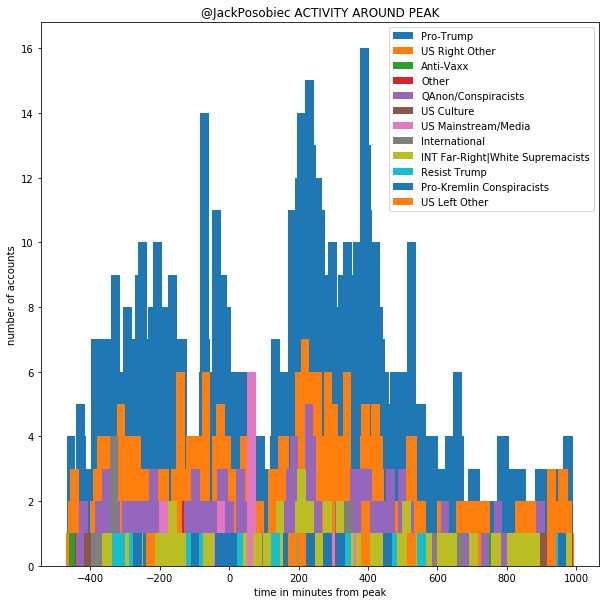

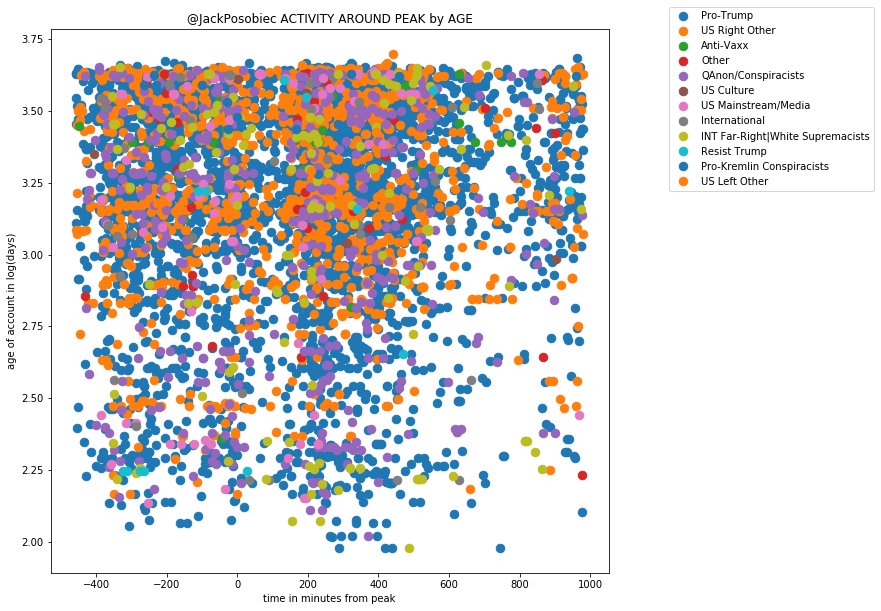

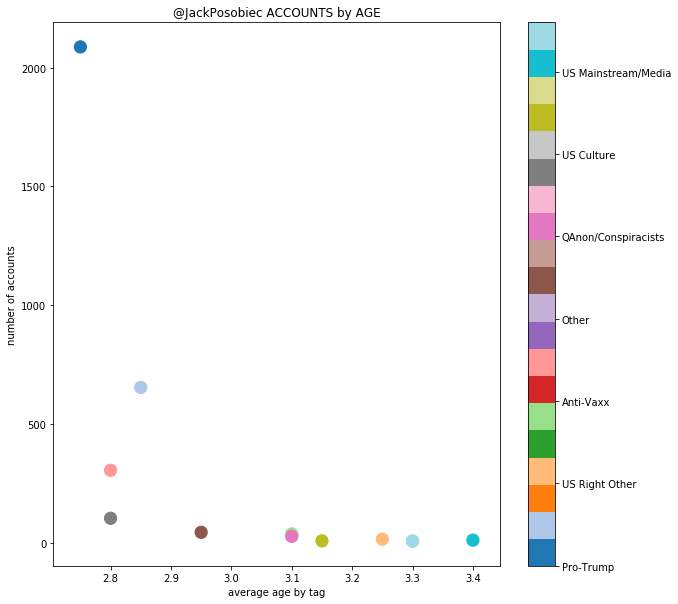

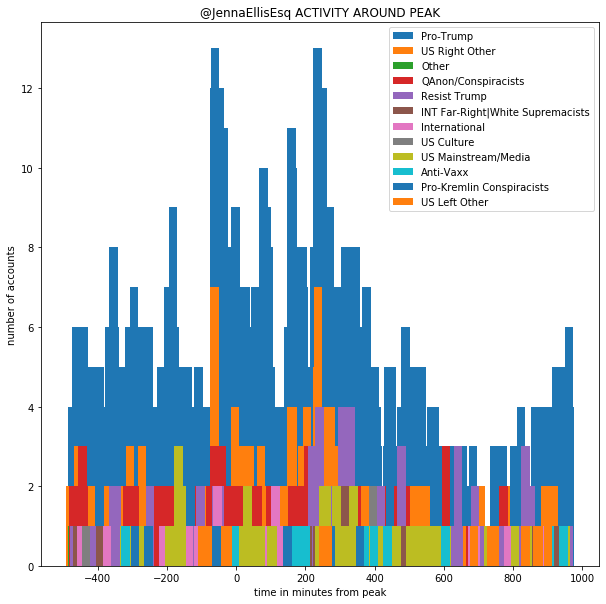

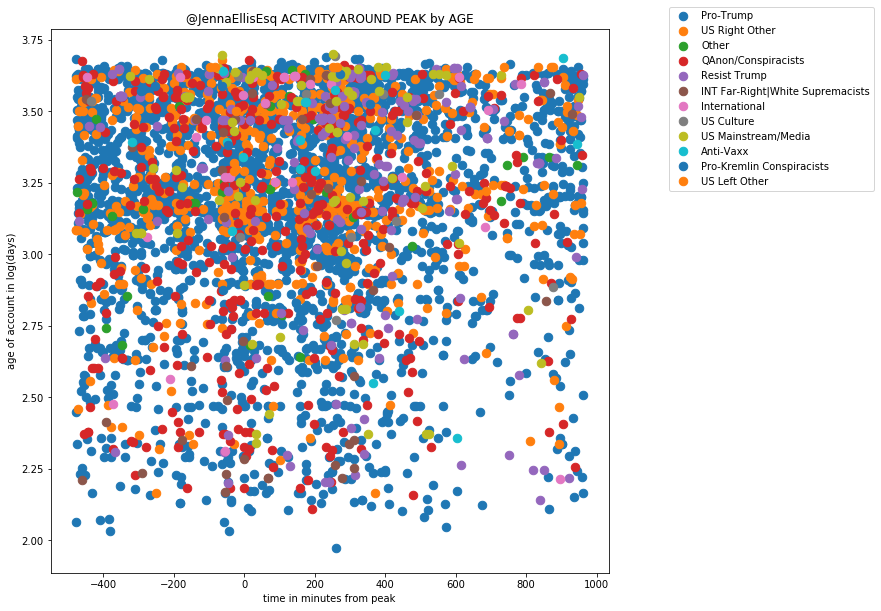

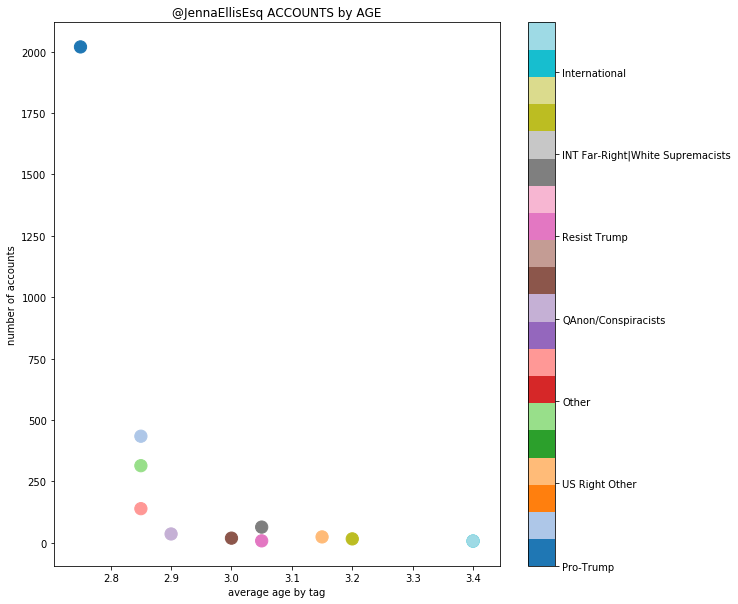

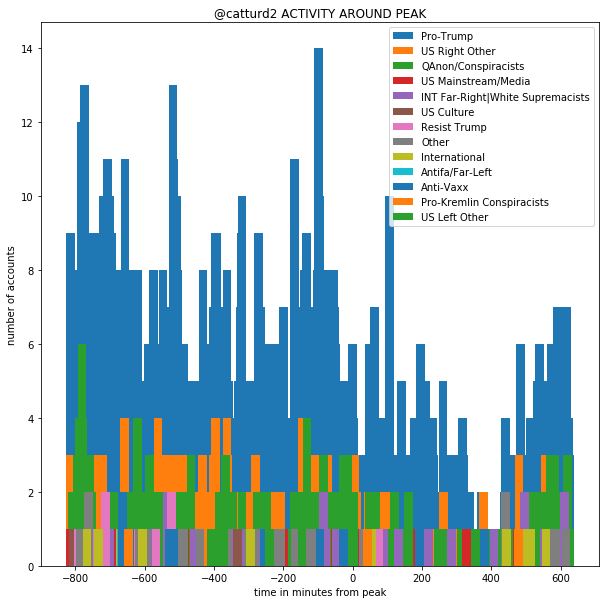

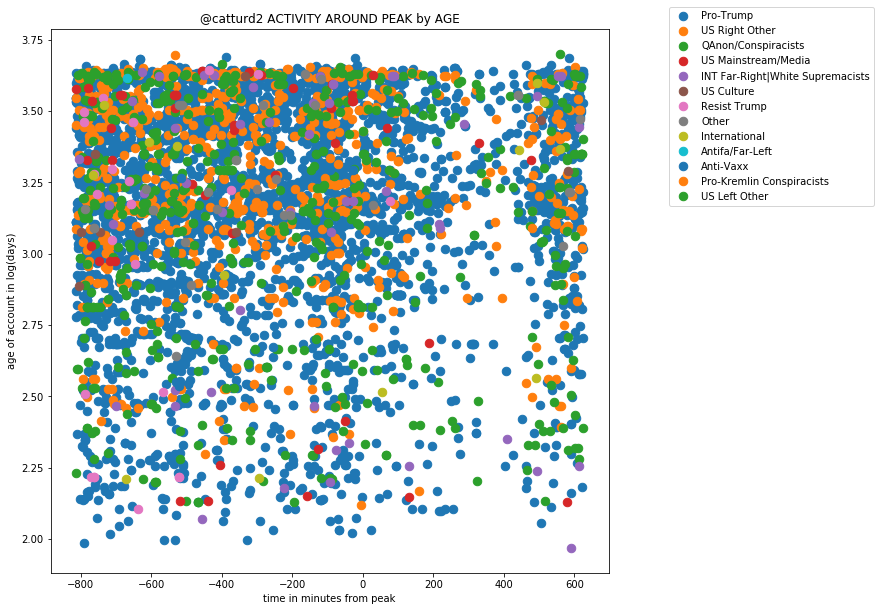

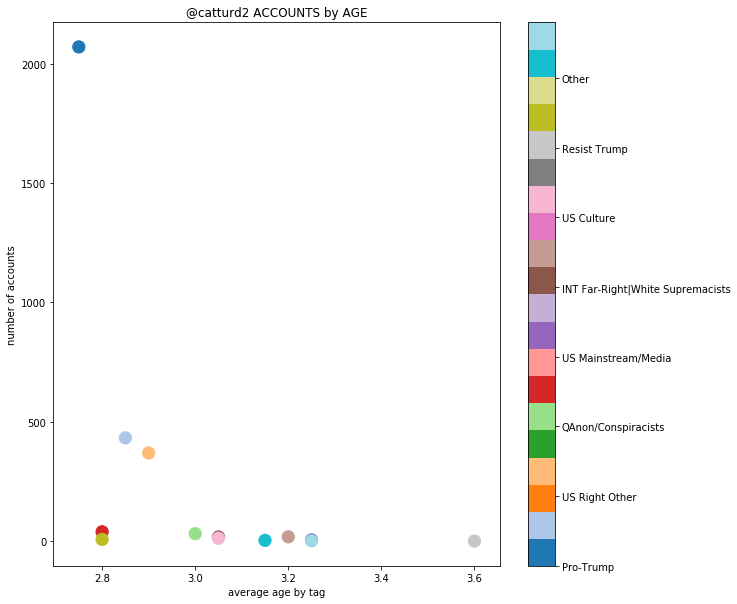

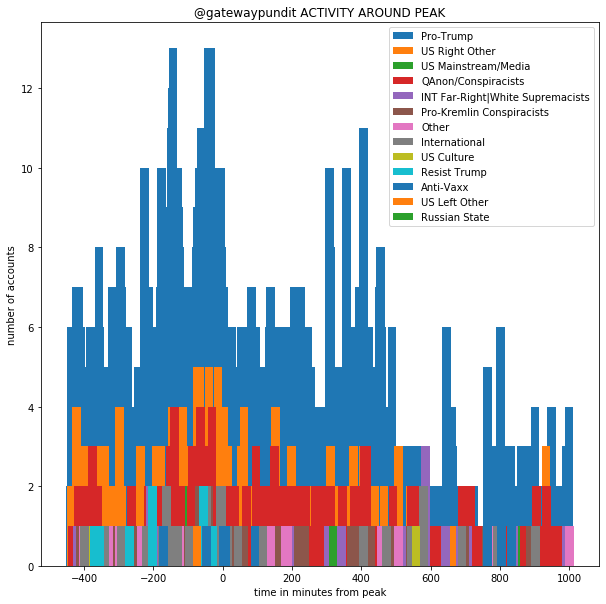

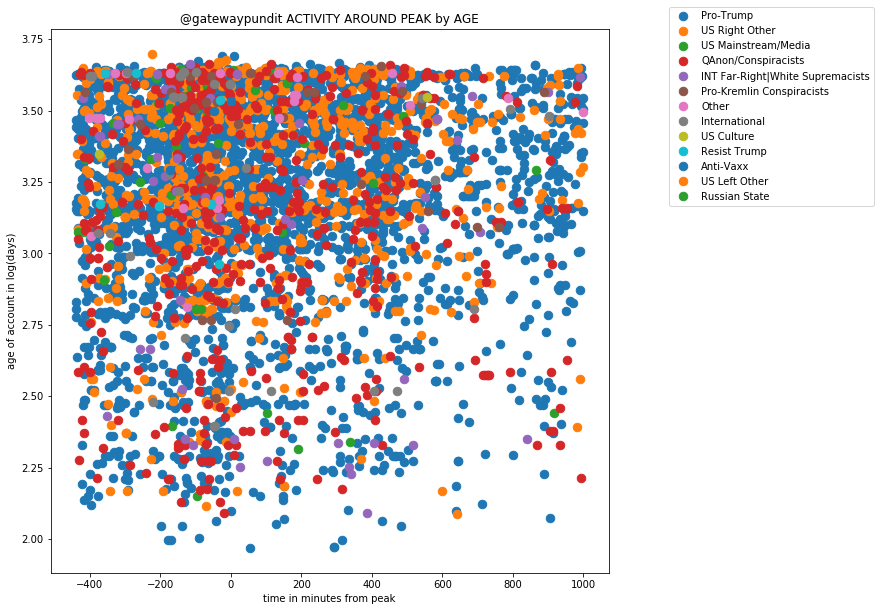

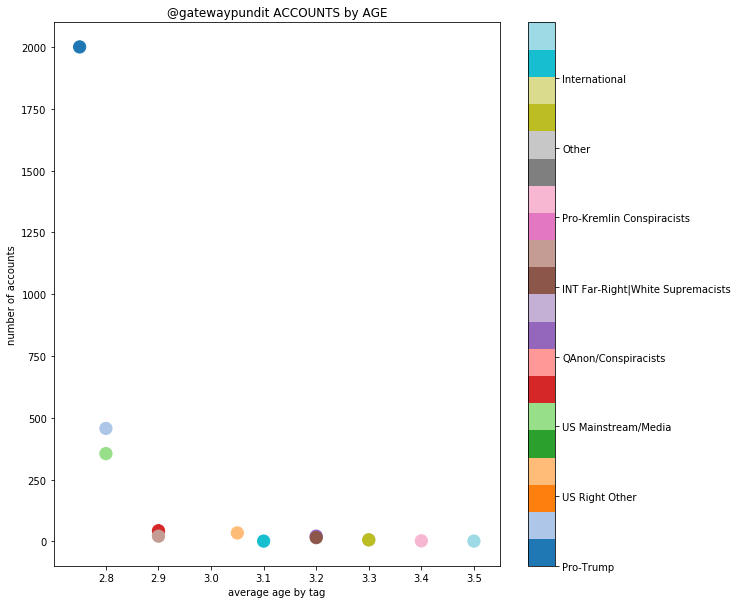

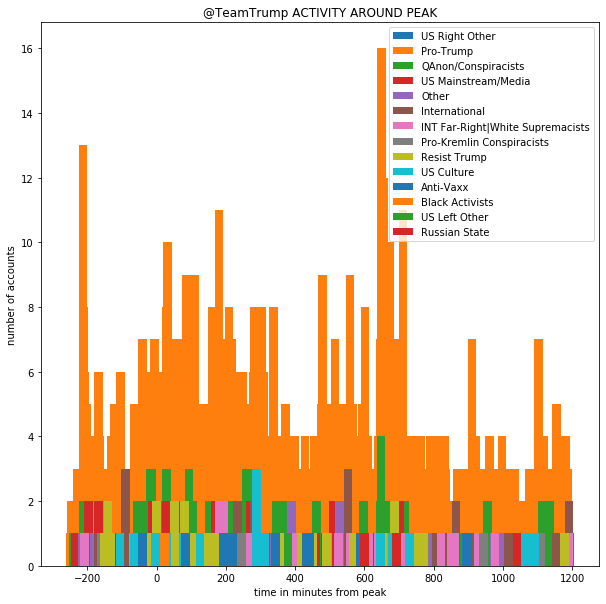

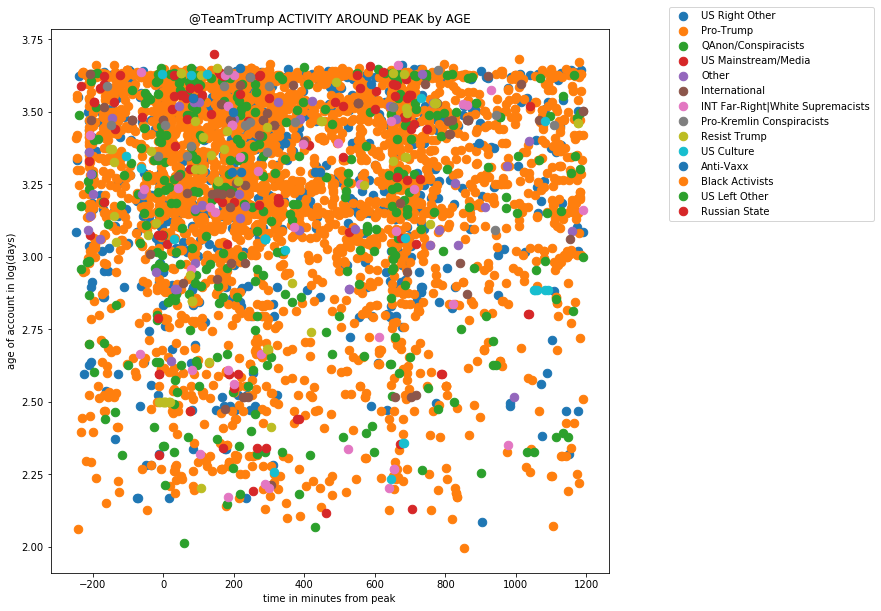

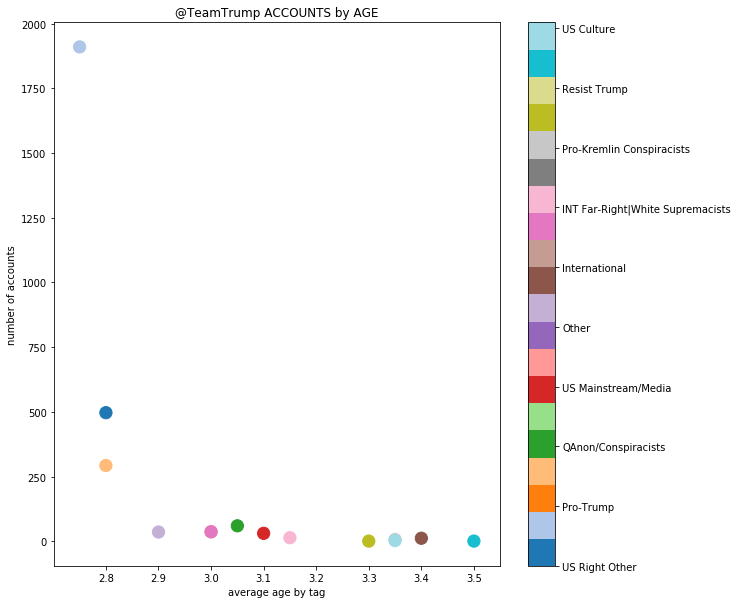

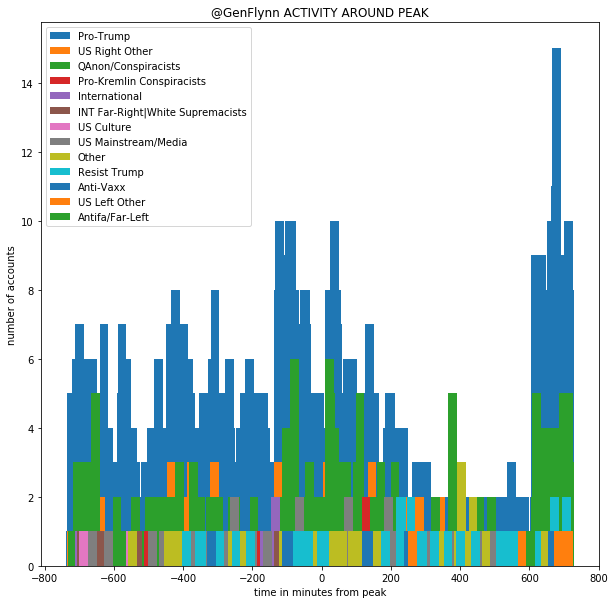

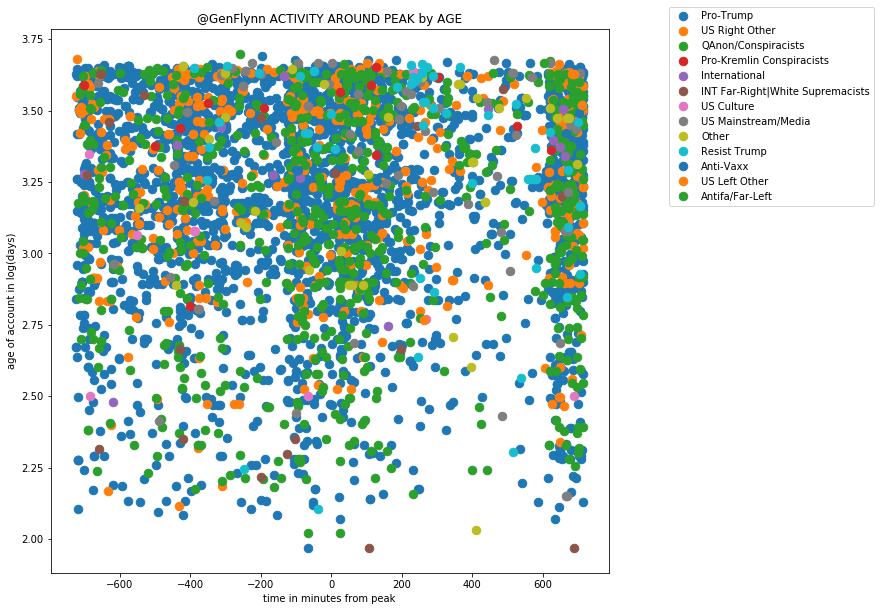

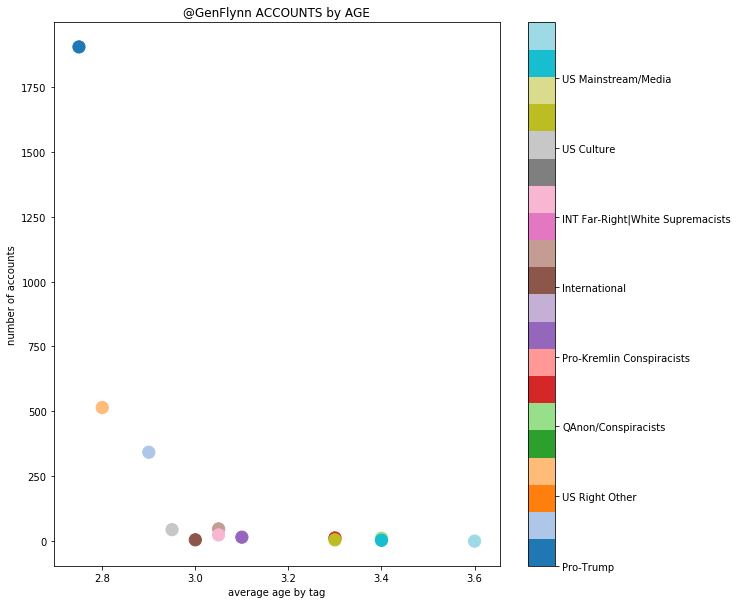

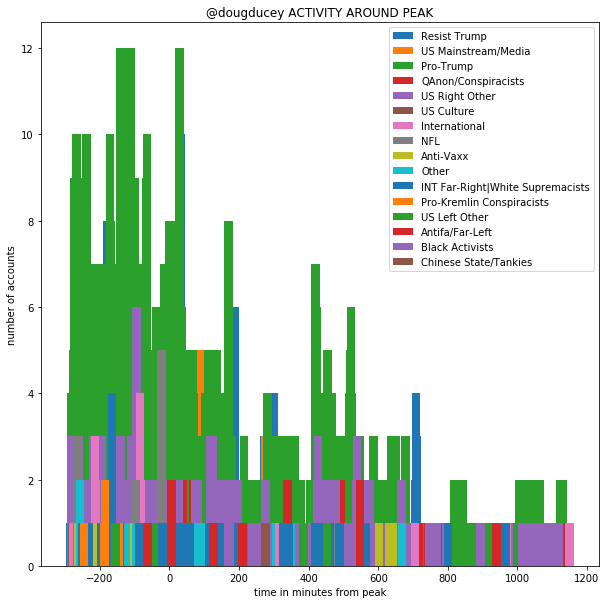

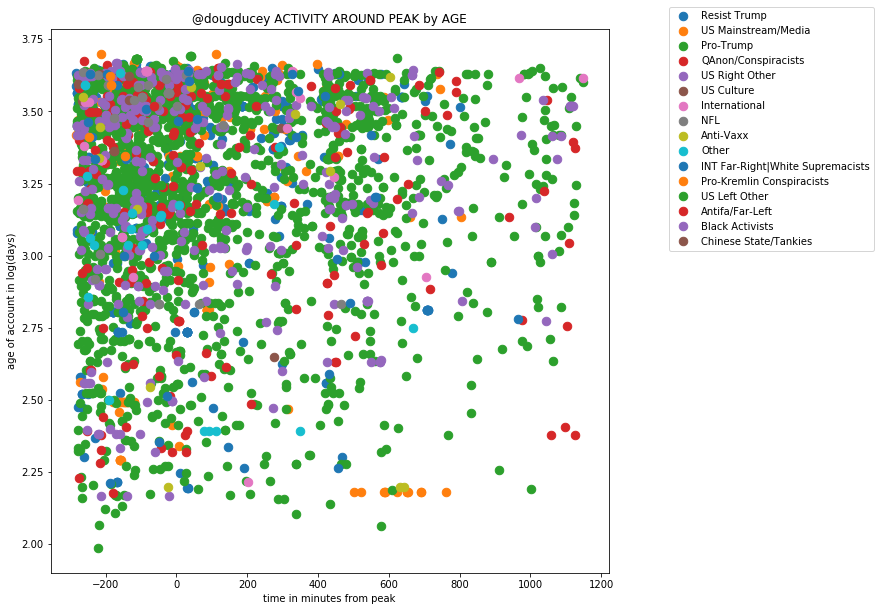

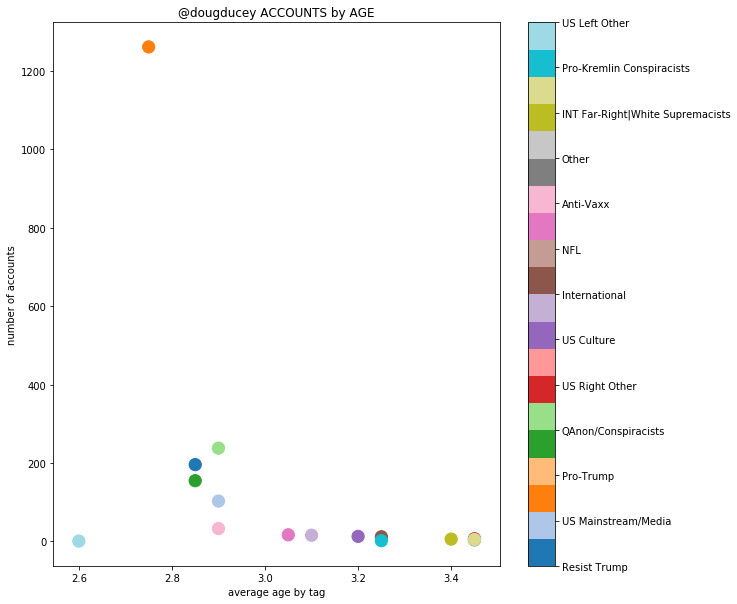

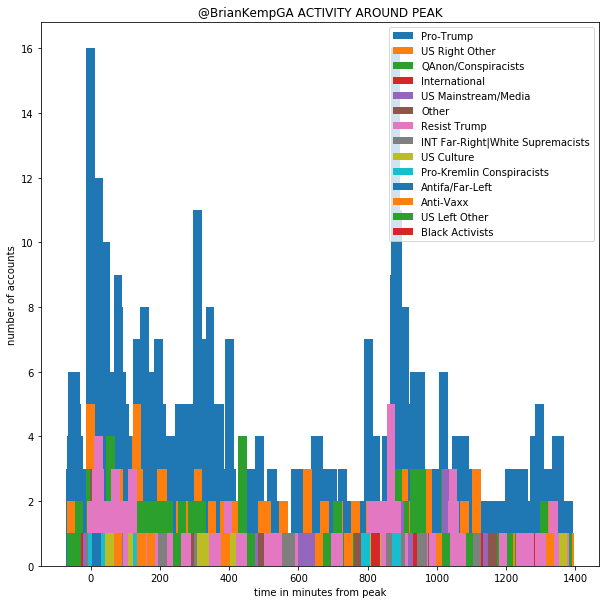

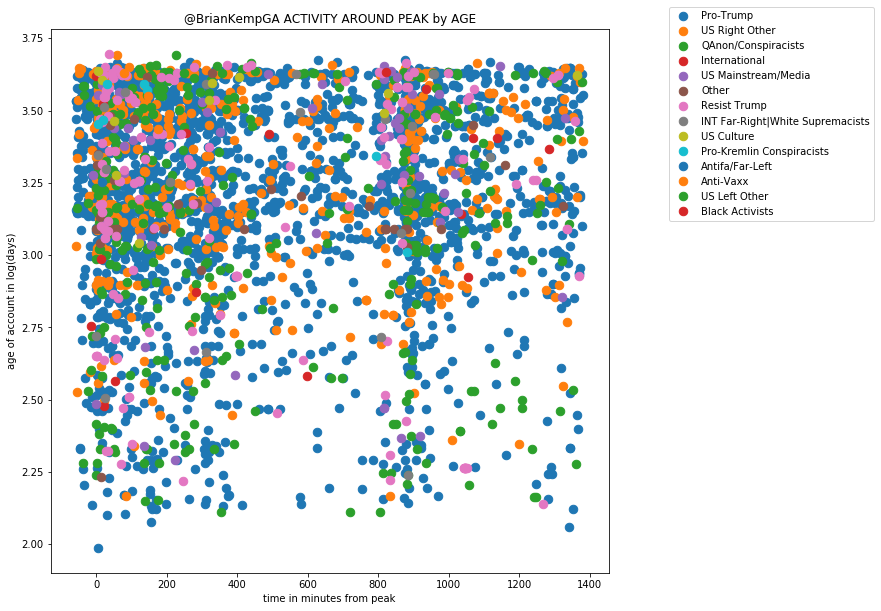

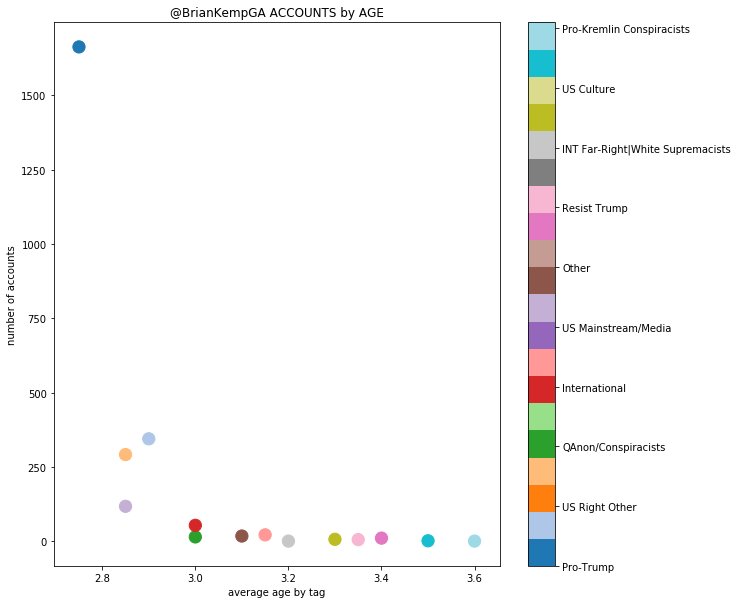

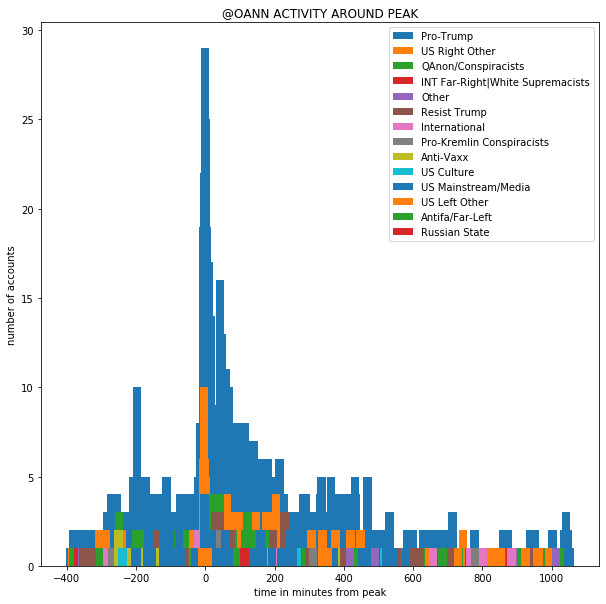

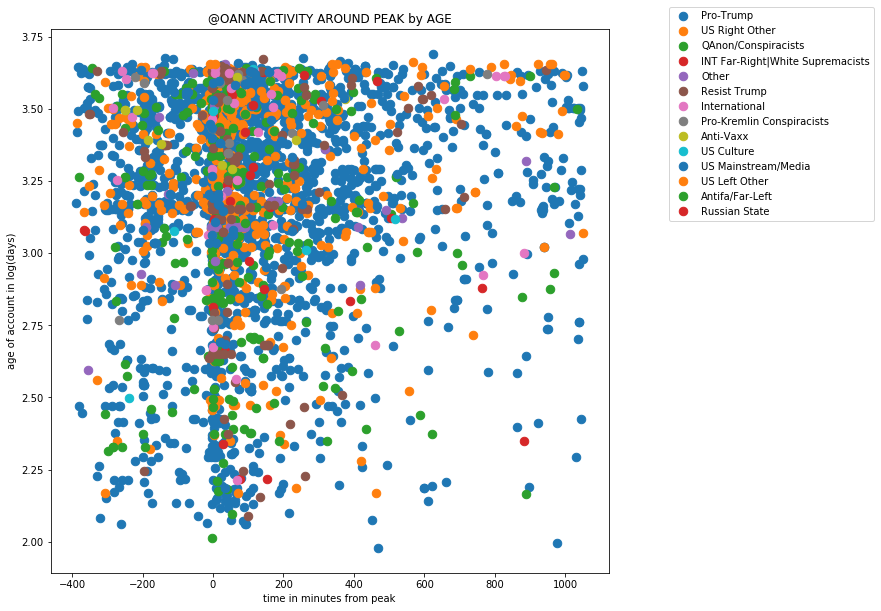

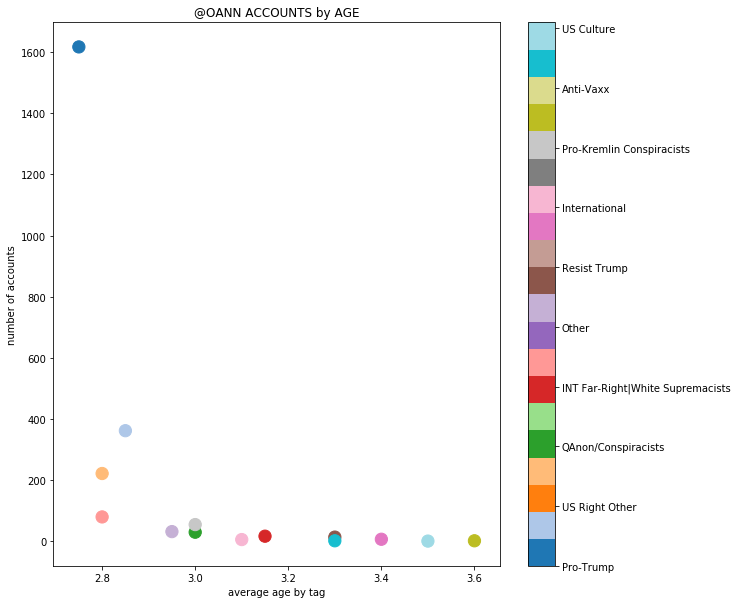

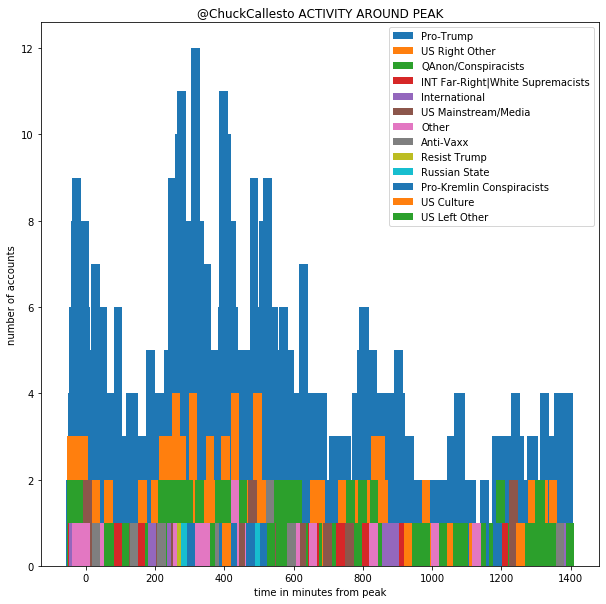

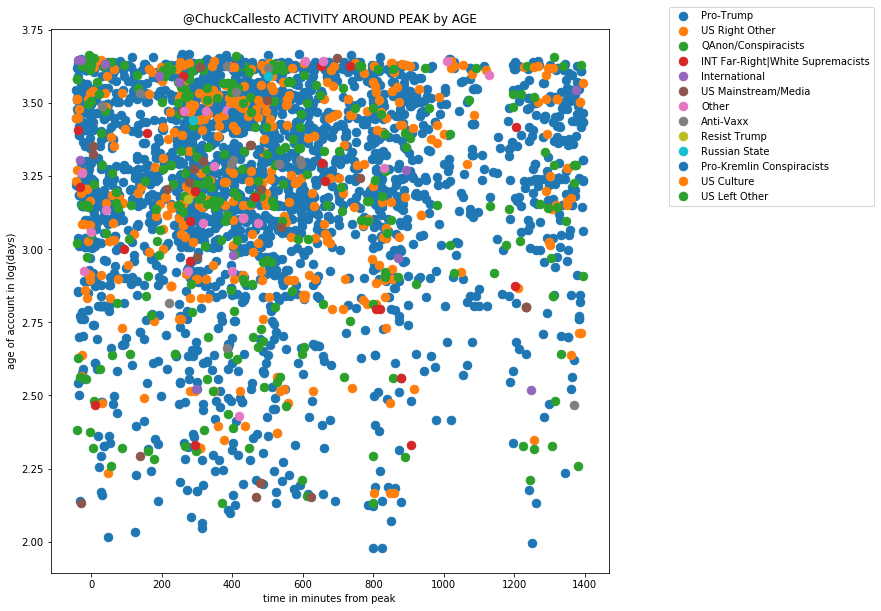

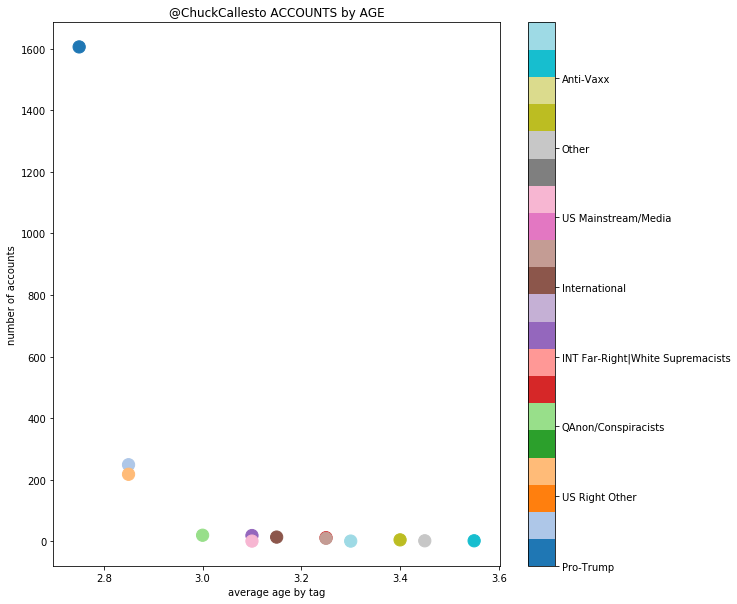

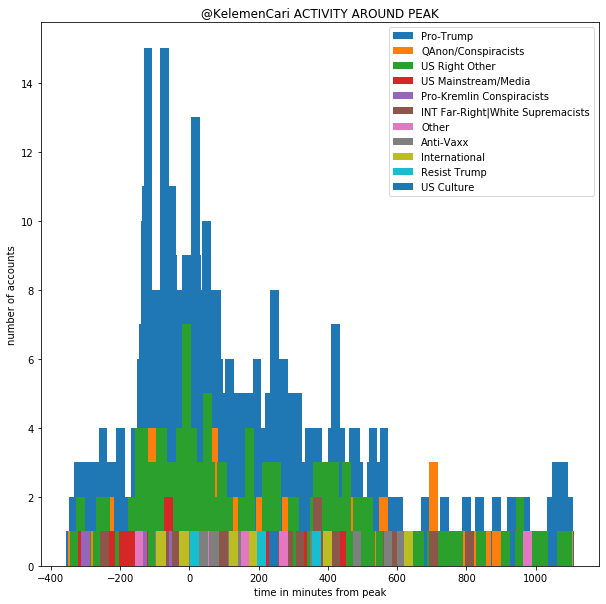

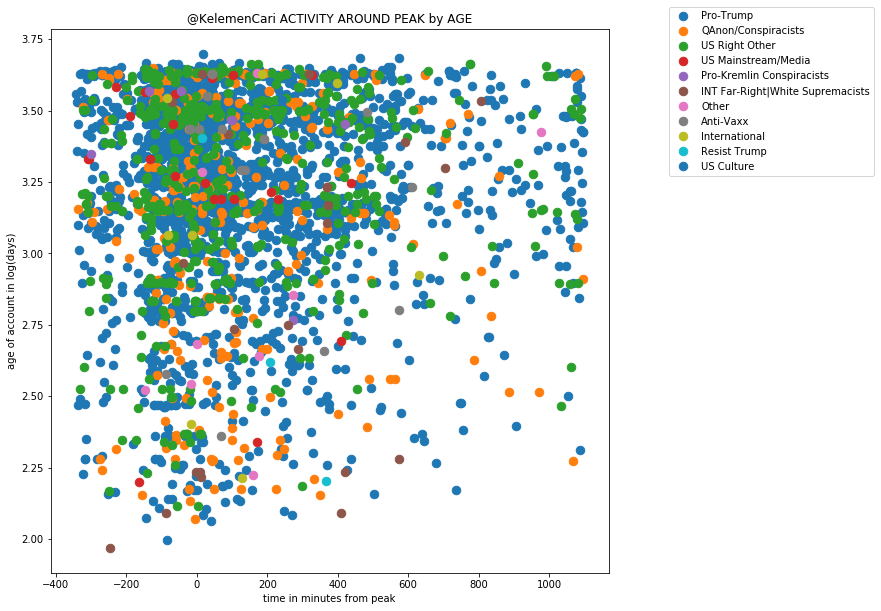

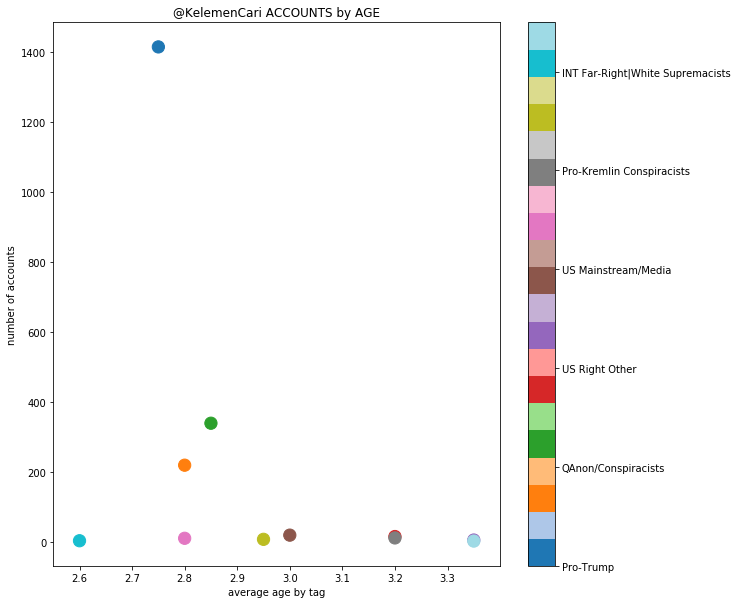

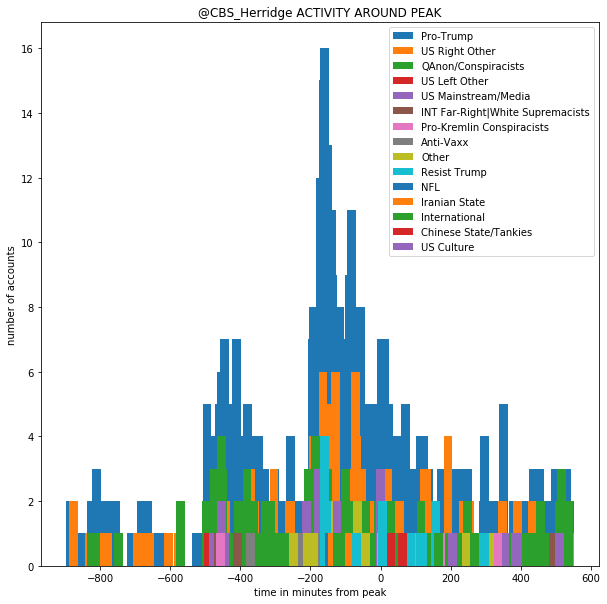

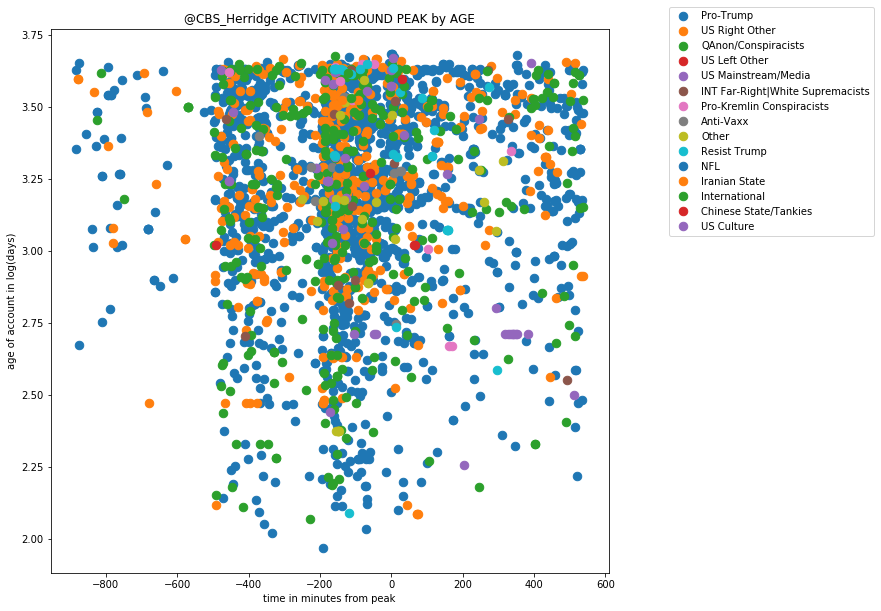

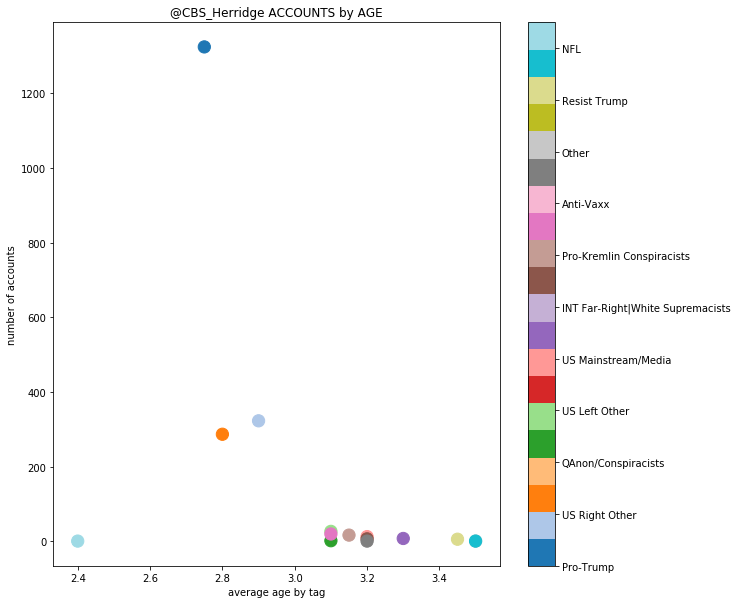

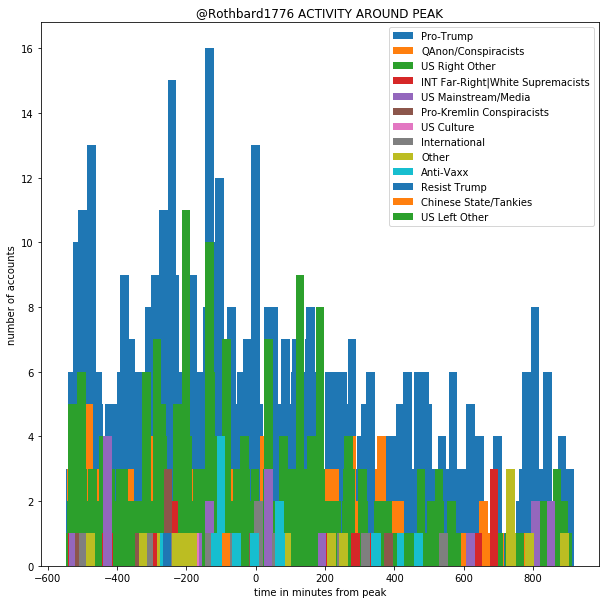

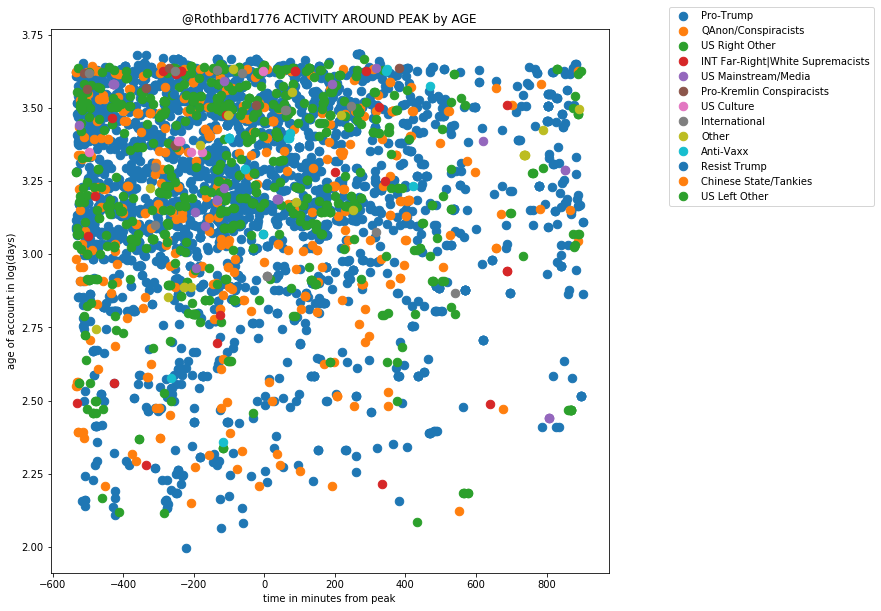

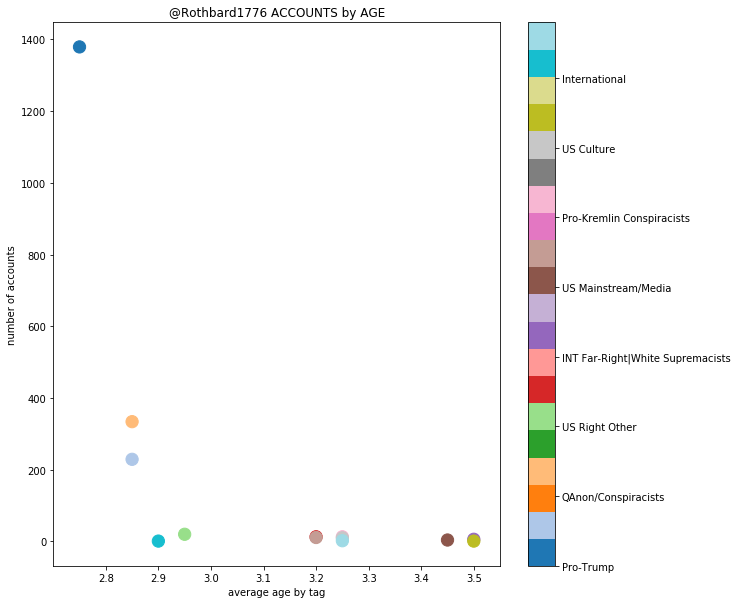

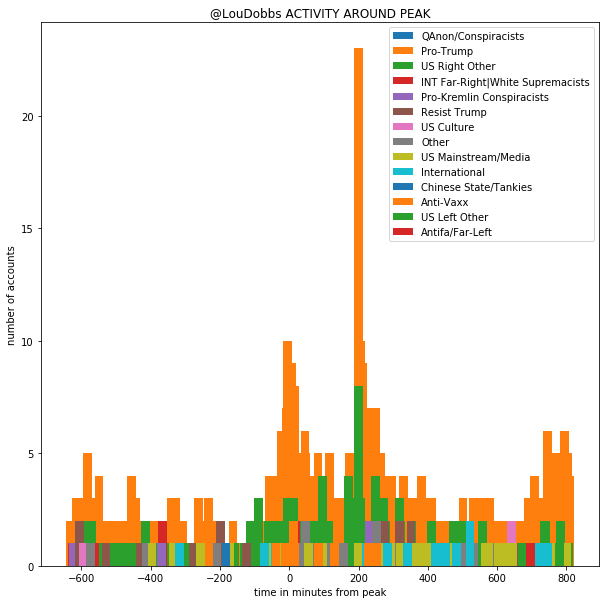

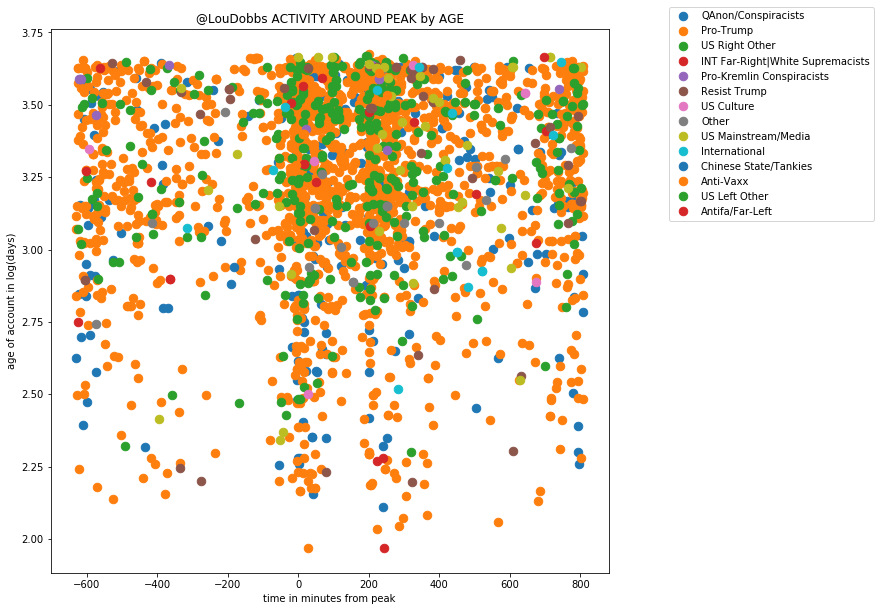

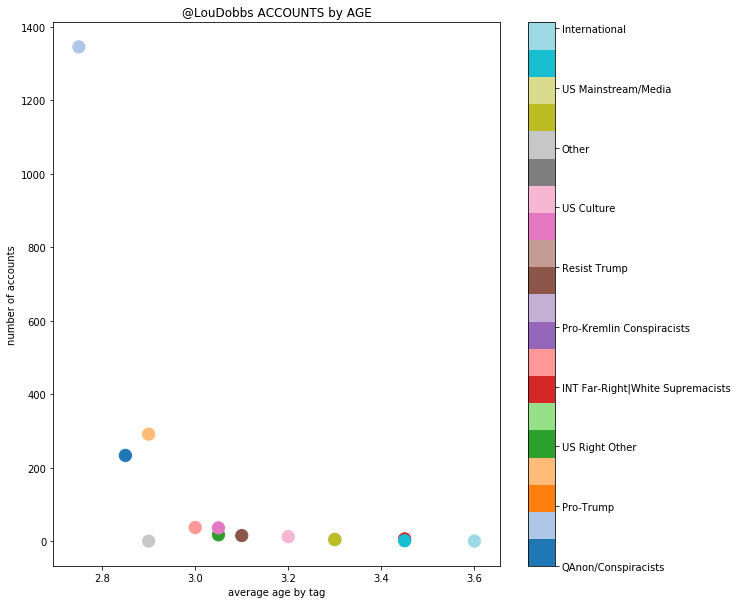

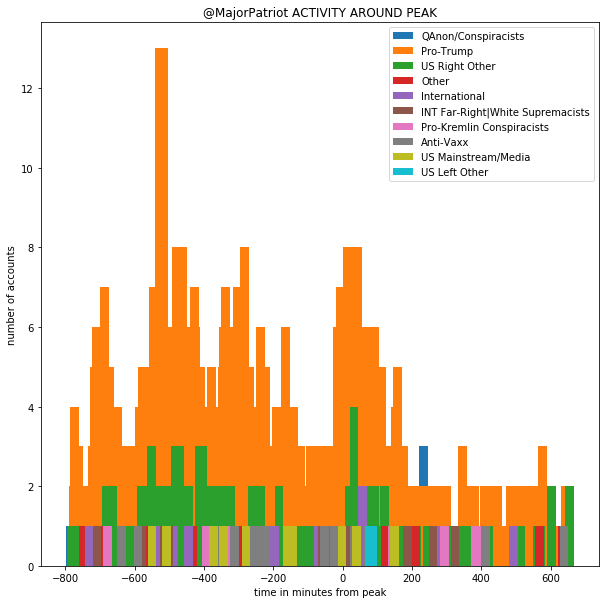

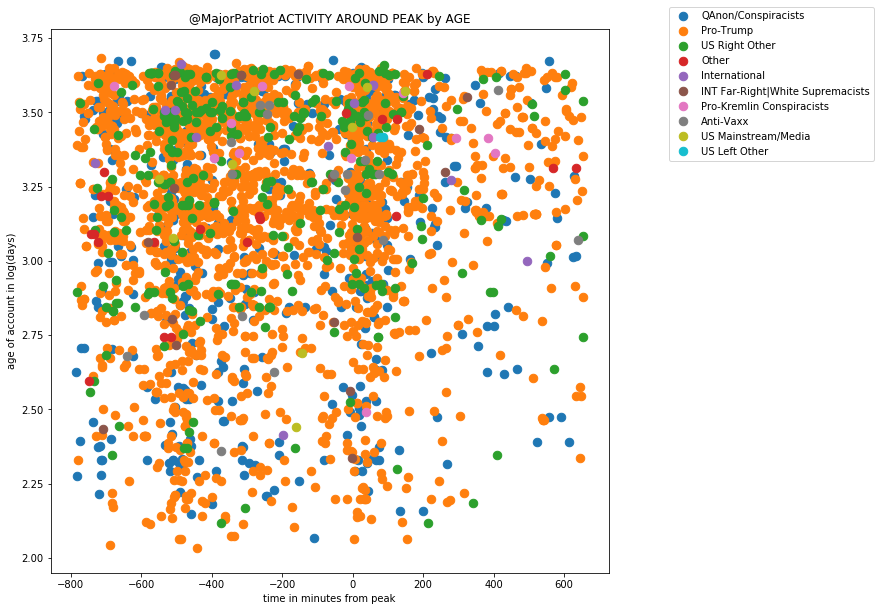

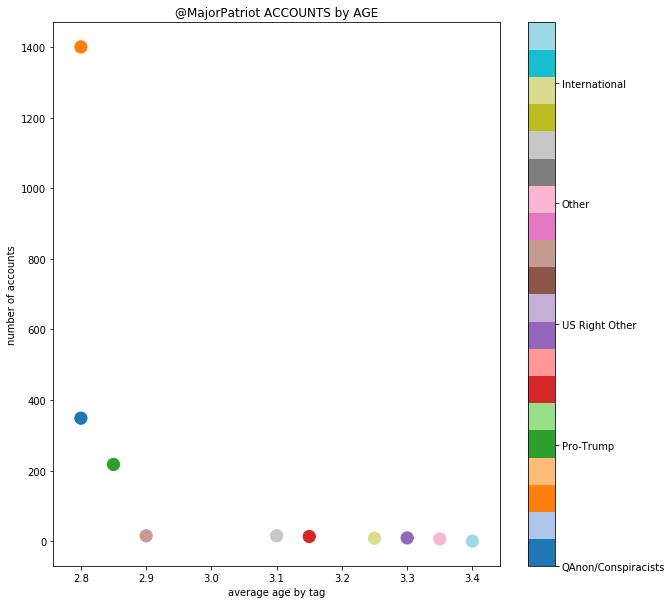

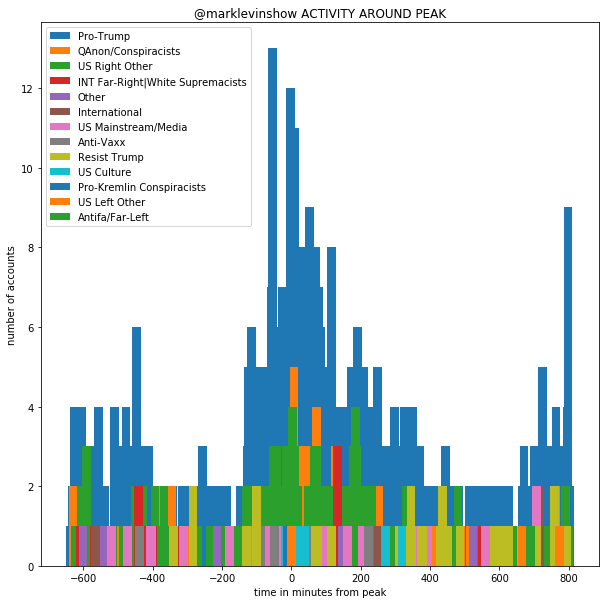

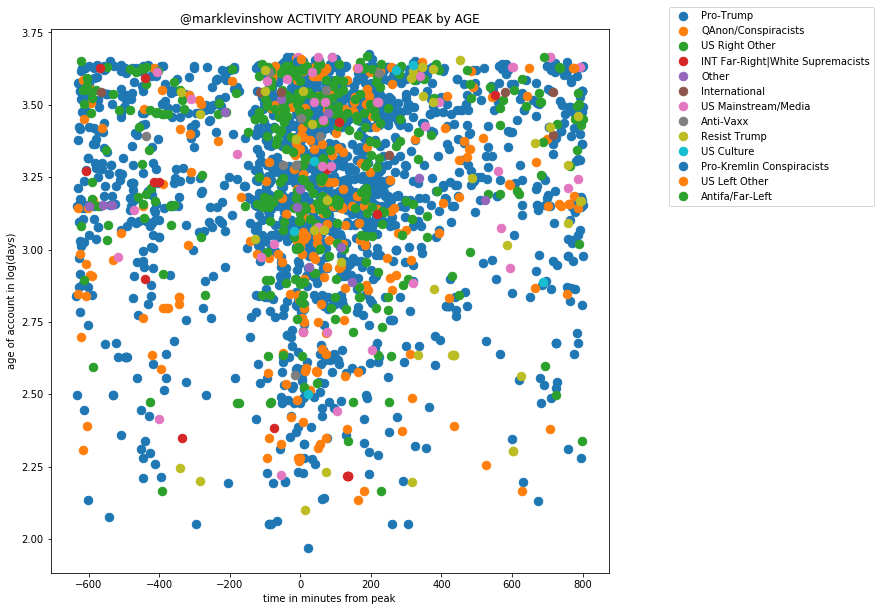

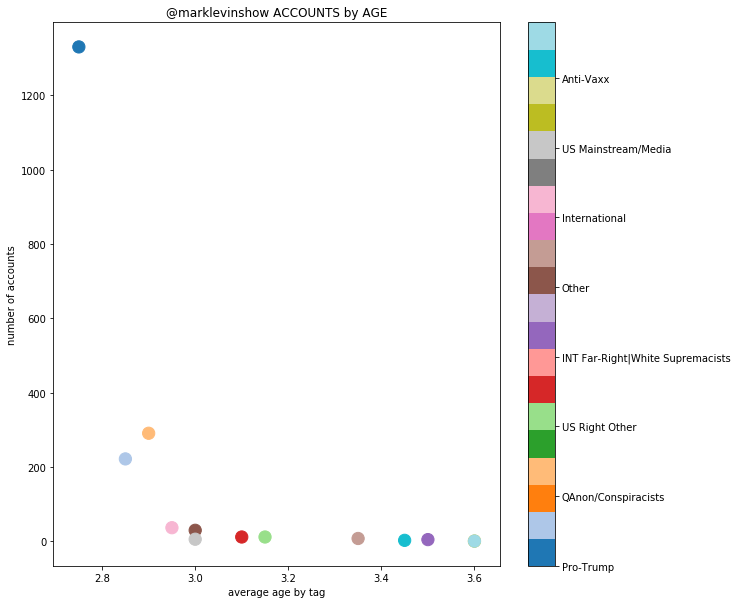

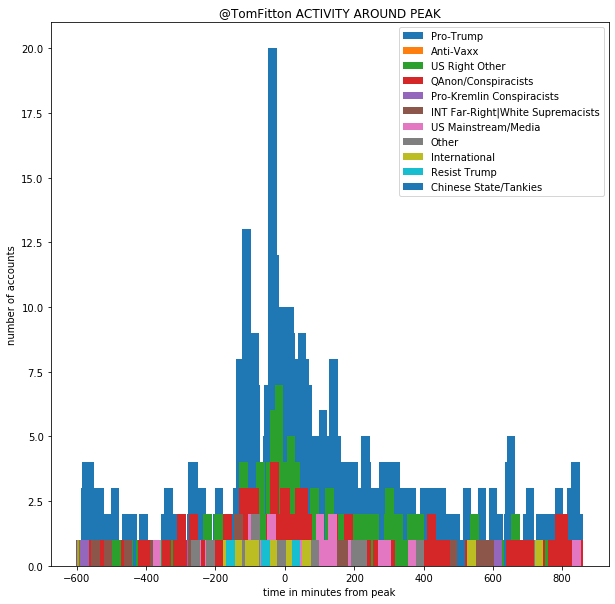

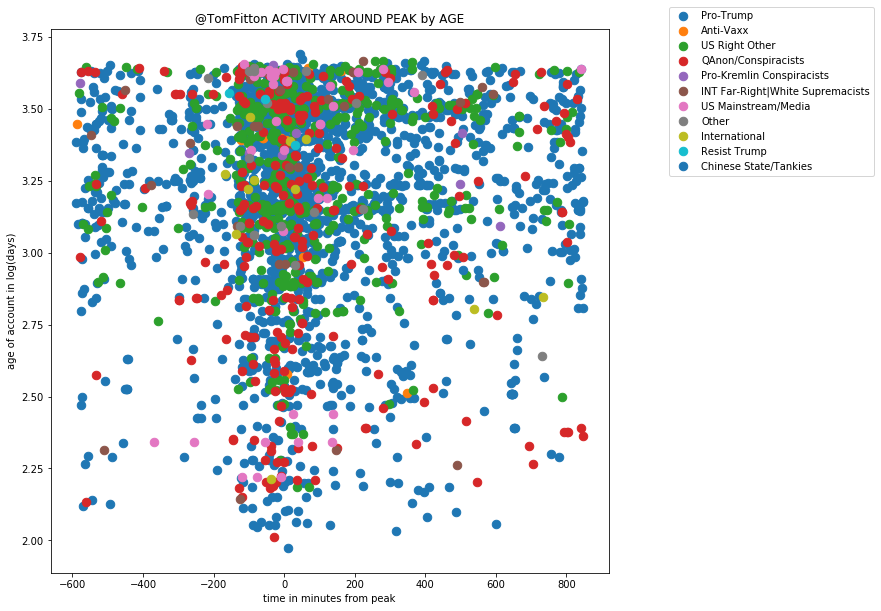

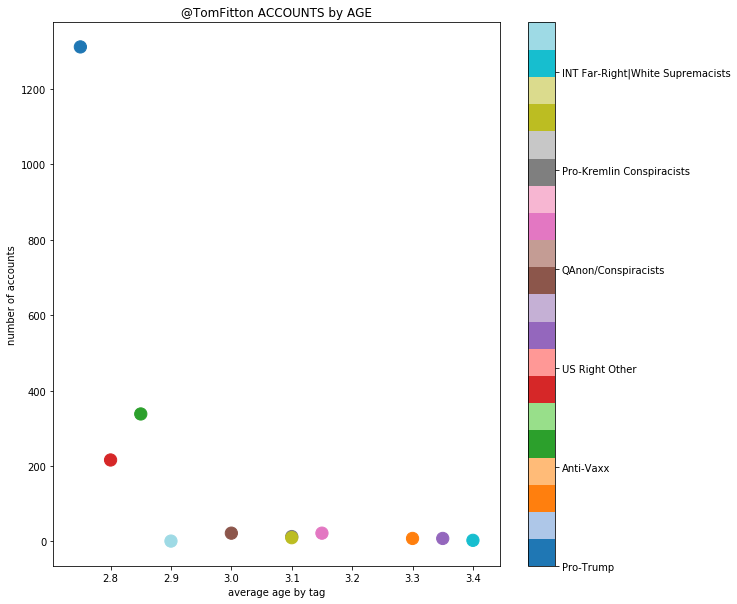

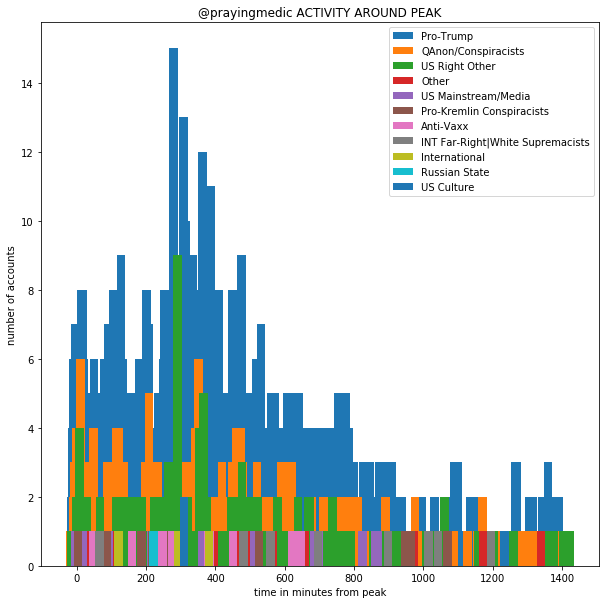

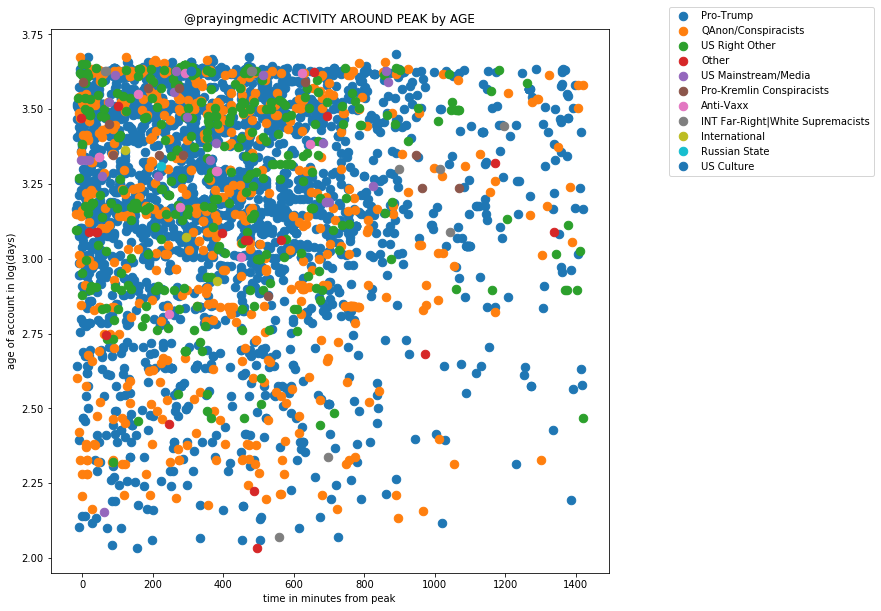

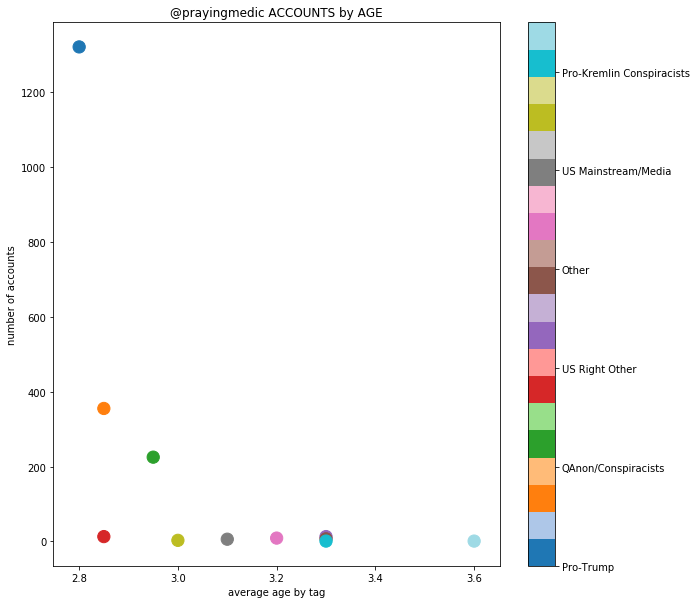

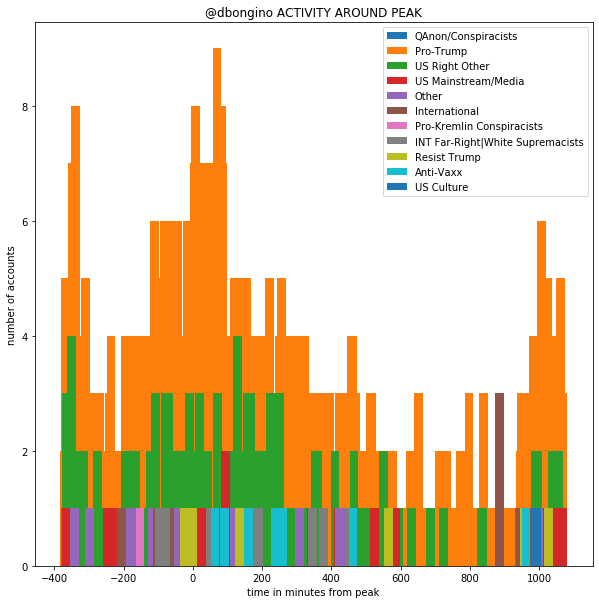

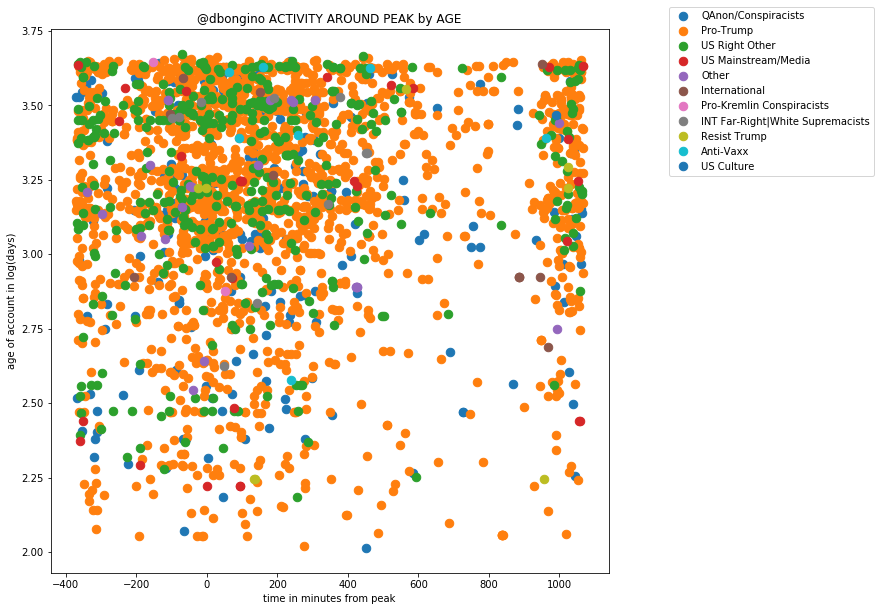

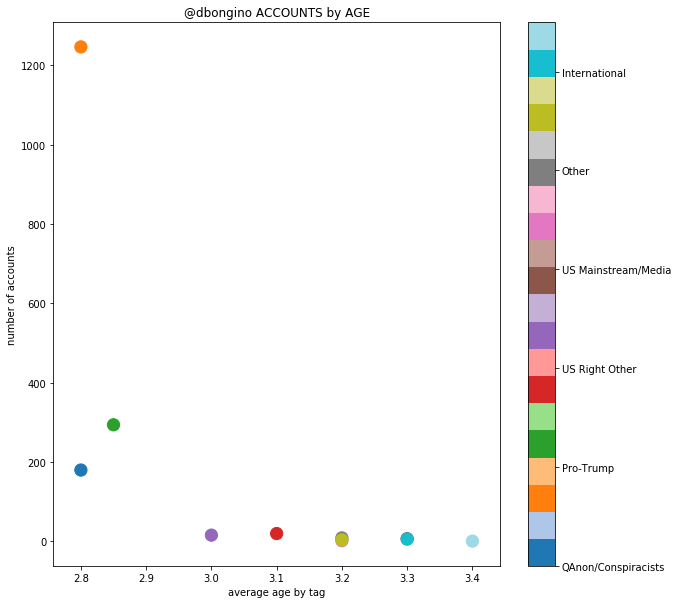

In [356]:
enum_temp = pd.DataFrame(enumerate(mench.tag.unique(),0))
enum_temp.columns = ['enum_tag','tag']
for user in rel_men[0:20]:
# for user in ['25073877']:
    about = '@' + mench[mench.hit_value == user].screen_name.values[0]
    temp = get_posting_gaps(mench[mench.hit_value == user])
    
#     to_plot = pd.pivot_table(temp,index = ['tag','gap'],values = 'node_id',aggfunc = pd.Series.nunique)
#     to_plot = to_plot.reset_index()
#     enum_temp.merge(to_plot[['tag']])['enum_tag']
#     enum_tag = enum_temp.merge(to_plot[['tag']],how='right')['enum_tag']
#     plt.scatter(to_plot.gap,to_plot.node_id,c=enum_tag,cmap = 'tab20')
#     cbar = plt.colorbar()
#     cbar.set_ticks([i[0]*20/temp.tag.nunique() for i in list(enumerate(temp.tag.unique(),0))])
#     cbar.set_ticklabels([i[1] for i in list(enumerate(temp.tag.unique(),0))])
#     plt.show()

#     plt.figure(figsize=plt_args['dims'])
#     for t in to_plot.tag.unique():
#         to_plot_temp = to_plot[to_plot.tag == t]
#         plt.plot(to_plot_temp.gap,to_plot_temp.node_id,'-',label = t,markersize=plt_args['size'])
#     plt.legend()
    
    plt.figure(figsize=plt_args['dims'])
    for t in temp.tag.unique():
        to_plot_temp = temp[temp.tag == t].gap.value_counts()
        plt.bar(to_plot_temp.index,to_plot_temp.values,width = 25,label = t)
    #     plt.xticks(ind + (wid/2))
    plt.legend()
#     bbox_to_anchor=(1.1, 1.05)
    plt.xlabel('time in minutes from peak')
    plt.ylabel('number of accounts')
    plt.title(about + ' ACTIVITY AROUND PEAK')
    plt.show()
    
    
    plt.figure(figsize=plt_args['dims'])
    for t in temp.tag.unique():
        to_plot_temp = temp[temp.tag == t]
        plt.plot(to_plot_temp.gap,to_plot_temp.created_gap,'.',label = t,markersize=plt_args['size'])
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
    plt.xlabel('time in minutes from peak')
    plt.ylabel('age of account in log(days)')
    plt.title(about + ' ACTIVITY AROUND PEAK by AGE')
    plt.show()
    
    to_plot = temp
    to_plot.created_gap = [int(10*x) for x in to_plot.created_gap]
    to_plot.created_gap = [float(x/10.0) for x in to_plot.created_gap]
    to_plot = pd.pivot_table(to_plot,index = ['tag','created_gap'],values = 'node_id',aggfunc = pd.Series.nunique)
    to_plot = to_plot.reset_index()
#     enum_temp.merge(to_plot[['tag']])['enum_tag']
#     enum_tag = enum_temp.merge(to_plot[['tag']],how='right')['enum_tag']
    plt.figure(figsize=plt_args['dims'])
    values = {'x':[],'y':[]}
    for t in temp.tag.unique():
        to_plot_temp = to_plot[to_plot.tag == t]
        values['x'].append(to_plot_temp.created_gap.median())
        values['y'].append(to_plot_temp.node_id.sum())
#         plt.plot(to_plot_temp.created_gap,to_plot_temp.node_id,'.',label = t,markersize=plt_args['size'])
    zval = [i[0] for i in list(enumerate(temp.tag.unique(),0))]
    temp_map = plt.scatter(values['x'],values['y'],c=zval,cmap = 'tab20',marker = 'o',s=150)
    cbar = plt.colorbar(temp_map)
    cbar.set_ticks([i[0]*20/temp.tag.nunique() for i in list(enumerate(temp.tag.unique(),0))])
    cbar.set_ticklabels([i[1] for i in list(enumerate(temp.tag.unique(),0))])
    plt.xlabel('average age by tag')
    plt.ylabel('number of accounts')
#     plt.legend(bbox_to_anchor=(1.1, 1.05))

#     plt.xlabel('age of account in log(days)')
#     plt.ylabel('number of accounts')
    plt.title(about + ' ACCOUNTS by AGE')
    plt.show()

In [ ]:
median_ages = []
covered = []
for row in mench.head(3000).iterrows():
    u = row[1].hit_value
    if u in covered:
        continue
    covered.append(u)
    temp = mench[mench.node_id == u]
#     temp.created_at = pd.to_datetime(temp.created_at, infer_datetime_format = True,utc = True)
    if (temp.sort_values('created_at')).empty:
        continue
    avg_age = temp.sort_values('created_at').iloc[(int(temp.shape[0]/2))].created_at
    median_ages.append({'user':u,'tag':row[1].tag,'created_at':row[1].created_at,'median_age':avg_age})
median_ages = pd.DataFrame(median_ages).drop_duplicates()

In [177]:

# median_ages
median_ages.created_at = pd.to_datetime(median_ages.created_at, infer_datetime_format = True,utc = True)
median_ages.median_age = pd.to_datetime(median_ages.median_age, infer_datetime_format = True,utc = True)

In [178]:
gap = []
for row in median_ages.iterrows():
    gap.append(divmod(abs(pd.Timedelta(row[1].created_at - row[1].median_age).total_seconds()), 86400)[0]/365)
median_ages['gap'] = gap

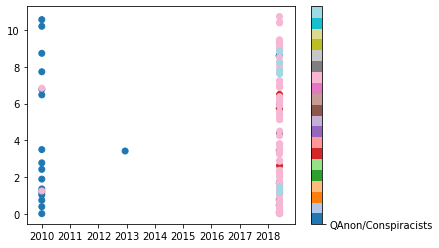

In [179]:
enum_temp = pd.DataFrame(enumerate(median_ages.tag.unique(),0))
enum_temp.columns = ['enum_tag','tag']
enum_temp.merge(median_ages[['tag']])['enum_tag']
enum_tag = enum_temp.merge(median_ages[['tag']],how='right')['enum_tag']
temp_map = plt.scatter(median_ages.created_at,median_ages.gap,c = enum_tag,cmap = 'tab20')
cbar = plt.colorbar(temp_map)
cbar.set_ticks([i[0]*20/median_ages.tag.nunique() for i in list(enumerate(median_ages.tag.unique(),0))])
cbar.set_ticklabels([i[1] for i in list(enumerate(median_ages.tag.unique(),0))])
plt.show()

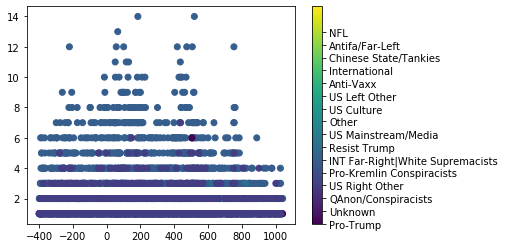

In [44]:
# plt.scatter(temp.gap,temp.created_gap,s = [i[0] for i in list(enumerate(temp.tag.unique(),0))])
# # plt.xticks(rotation='vertical')
# plt.show()
# enum_tag = [i[0] for i in list(enumerate(temp.tag,0))]
to_plot = pd.pivot_table(temp,index = ['tag','gap'],values = 'node_id',aggfunc = pd.Series.nunique)
to_plot = to_plot.reset_index()
# enum_temp = pd.DataFrame(enumerate(to_plot.tag.unique(),0))
# enum_temp.columns = ['enum_tag','tag']
enum_temp.merge(to_plot[['tag']])['enum_tag']
enum_tag = enum_temp.merge(to_plot[['tag']],how='right')['enum_tag']
plt.scatter(to_plot.gap,to_plot.node_id,c=enum_tag)
# plt.colorbar()
cbar = plt.colorbar()

cbar.set_ticks([i[0] for i in list(enumerate(temp.tag.unique(),0))])

cbar.set_ticklabels([i[1] for i in list(enumerate(temp.tag.unique(),0))])

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def parse_domain(x):
    try:
        return x.split('//')[1].split('/')[0]
#         return x.split(".")[0].split('//')[1]
    except:
        return x

In [ ]:
# data[data.domain.dropna().str.contains('bit')]

In [ ]:
# data = data[['Link','User Name']].rename(columns = {'Link':'domain','User Name':'page'})

In [ ]:
# data.domain = [parse_domain(i) for i in data.domain.values]

In [ ]:
# data = data[~(data.domain.isna())]
# data = data[~(data.page.isna())]
# data = data[~(data.domain.str.contains('bit.ly'))]
# data = data[~(data.domain.str.contains('facebook'))]

In [ ]:
# data = 
# data[(data.domain.str.contains('google.com'))]

In [ ]:
data[data.domain.str.contains('mmcelewave')]

In [ ]:
# pivot = pd.pivot_table(data,index = 'domain',values = 'page',aggfunc = pd.Series.nunique)\
# .sort_values('page')
# droplist = pivot[pivot.page <= 10].index.unique().values.tolist()
# droplist

In [ ]:
def generate_edgelist(temp):
    groupby_page = temp.fillna('').groupby('page')
    groupby_domain = temp.groupby('domain')
    single_mode = []
    for d in groupby_domain.groups:
        if d not in keeplist:
            continue
#         if 'www.facebook.com' in d or 'facebook.com' in d:
#             continue
#         if 'www.google.com' in d or 'google.com' in d:
#             continue
#         if 'www.bit.ly' in d:
#             continue
#         if d == 'nan' or d == '':
#             continue
        for p in groupby_domain.get_group(d).page.values:
#             if 'facebook.com' in p:
#                 continue
#             if 'google.com' in p:
#                 continue
#             if p == 'nan' or p == '':
#                 continue
            temp_links = groupby_page.get_group(p).domain.values.tolist()
            if temp_links == []:
                continue
            for l in temp_links:
                if d == l:
                    continue
                single_mode.append({'domain A':d,'domain B':l})
    return pd.DataFrame(single_mode)

In [ ]:
def generate_edgelist2(temp):
    groupby_page = temp.fillna('').groupby('page')
    groupby_domain = temp.groupby('domain')
    single_mode = []
    for p in groupby_page.groups:
#         if 'www.facebook.com' in d or 'facebook.com' in d:
#             continue
#         if 'www.google.com' in d or 'google.com' in d:
#             continue
#         if 'www.bit.ly' in d:
#             continue
#         if d == 'nan' or d == '':
#             continue
        for d in groupby_page.get_group(p).domain.values:
            if d not in keeplist:
                continue
#             if 'facebook.com' in p:
#                 continue
#             if 'google.com' in p:
#                 continue
#             if p == 'nan' or p == '':
#                 continue
            temp_links = groupby_domain.get_group(d).page.values.tolist()
            if temp_links == []:
                continue
            for l in temp_links:
                if p == l:
                    continue
                single_mode.append({'page A':d,'page B':l})
    return pd.DataFrame(single_mode)

In [ ]:
y = generate_edgelist2(data)

In [ ]:
y.shape#drop_duplicates().shape

In [ ]:
# y.head(int(y.shape[0]/2)).to_csv('myanmar_edgelist_page_1.csv',index = False)
# y.tail(int(y.shape[0]/2)).to_csv('myanmar_edgelist_page_2.csv',index = False)

In [ ]:
y = pd.DataFrame(y.value_counts()).reset_index()

In [ ]:
y.columns = ['Source','Target']

In [ ]:
y = y[~(y.Source.str.contains('google'))]
y = y[~(y.Target.str.contains('google'))]

In [ ]:
y = y.drop(columns = 0)

In [ ]:
y.to_csv('myanmar_edgelist_pages.csv',index = False)

In [ ]:
x = generate_edgelist(data)

In [ ]:
x.columns = ['Source','Target']

In [ ]:
# x = x[~(x.Target.str.contains('youtube'))]
# x = x[~(x.Source.str.contains('youtube'))]
# x = x[~(x.Source.str.contains('youtu.be'))]
# x = x[~(x.Target.str.contains('youtu.be'))]

In [ ]:
x.shape

In [ ]:
x = x.replace('www.kyautthinpone.com','kyautthinpone.com')

In [ ]:
x[x.Source.str.contains('kyautt')].value_counts()

In [ ]:
pd.Series(x.Source.values.tolist() + (x.Target.values.tolist())).nunique()

In [ ]:
# write_to_sheet({'edgelist':generate_edgelist(data)},'merged_myanmar_data')
x.to_csv('myanmar_edgelist.csv',index = False)

In [ ]:
t = pd.pivot_table(data,index = 'domain',values = 'page',aggfunc = pd.Series.nunique)

In [ ]:
droplist = t[t.page == 1].index.unique().values.tolist()

In [ ]:
keeplist = data.domain.value_counts()[data.domain.value_counts() > 10].index.tolist()

In [ ]:
for k in keeplist:
    if k in droplist:
        keeplist.remove(k)

In [ ]:
# keeplist

In [ ]:
x = check_hitcache('urls','tiktok',0.1,live = True, limit = False)

In [ ]:
[print(f'https://twitter.com/a/status/{i}') for i in x.message_id]